In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 1024

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 1024/1024 [00:21<00:00, 47.34it/s]


>>> Simulation completed


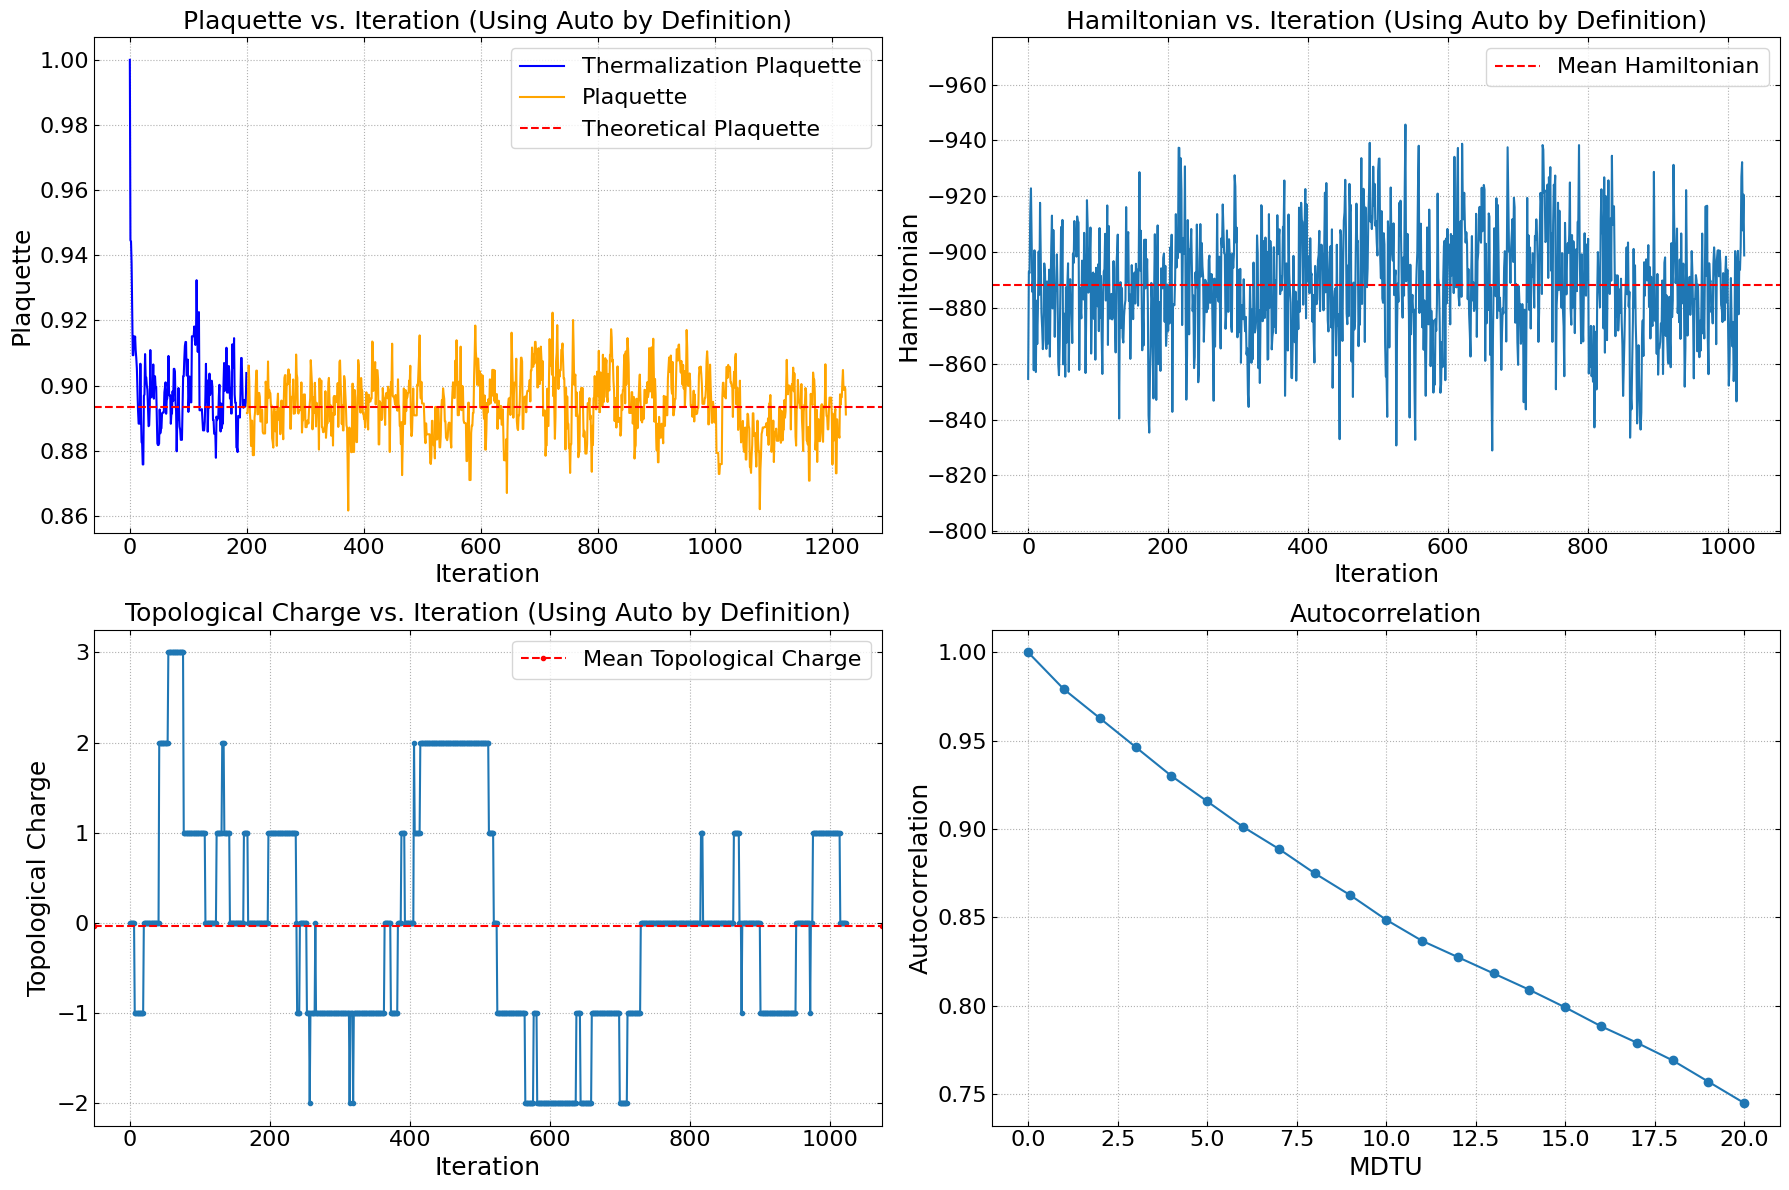

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8938422499340959
>>> Std of mean plaq:  0.0002858000192382453
Thermalization acceptance rate: 0.7850
Acceptance rate: 0.7969


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Manual Field Transformation

Running HMC: 100%|██████████| 1024/1024 [01:09<00:00, 14.73it/s]


>>> Simulation completed


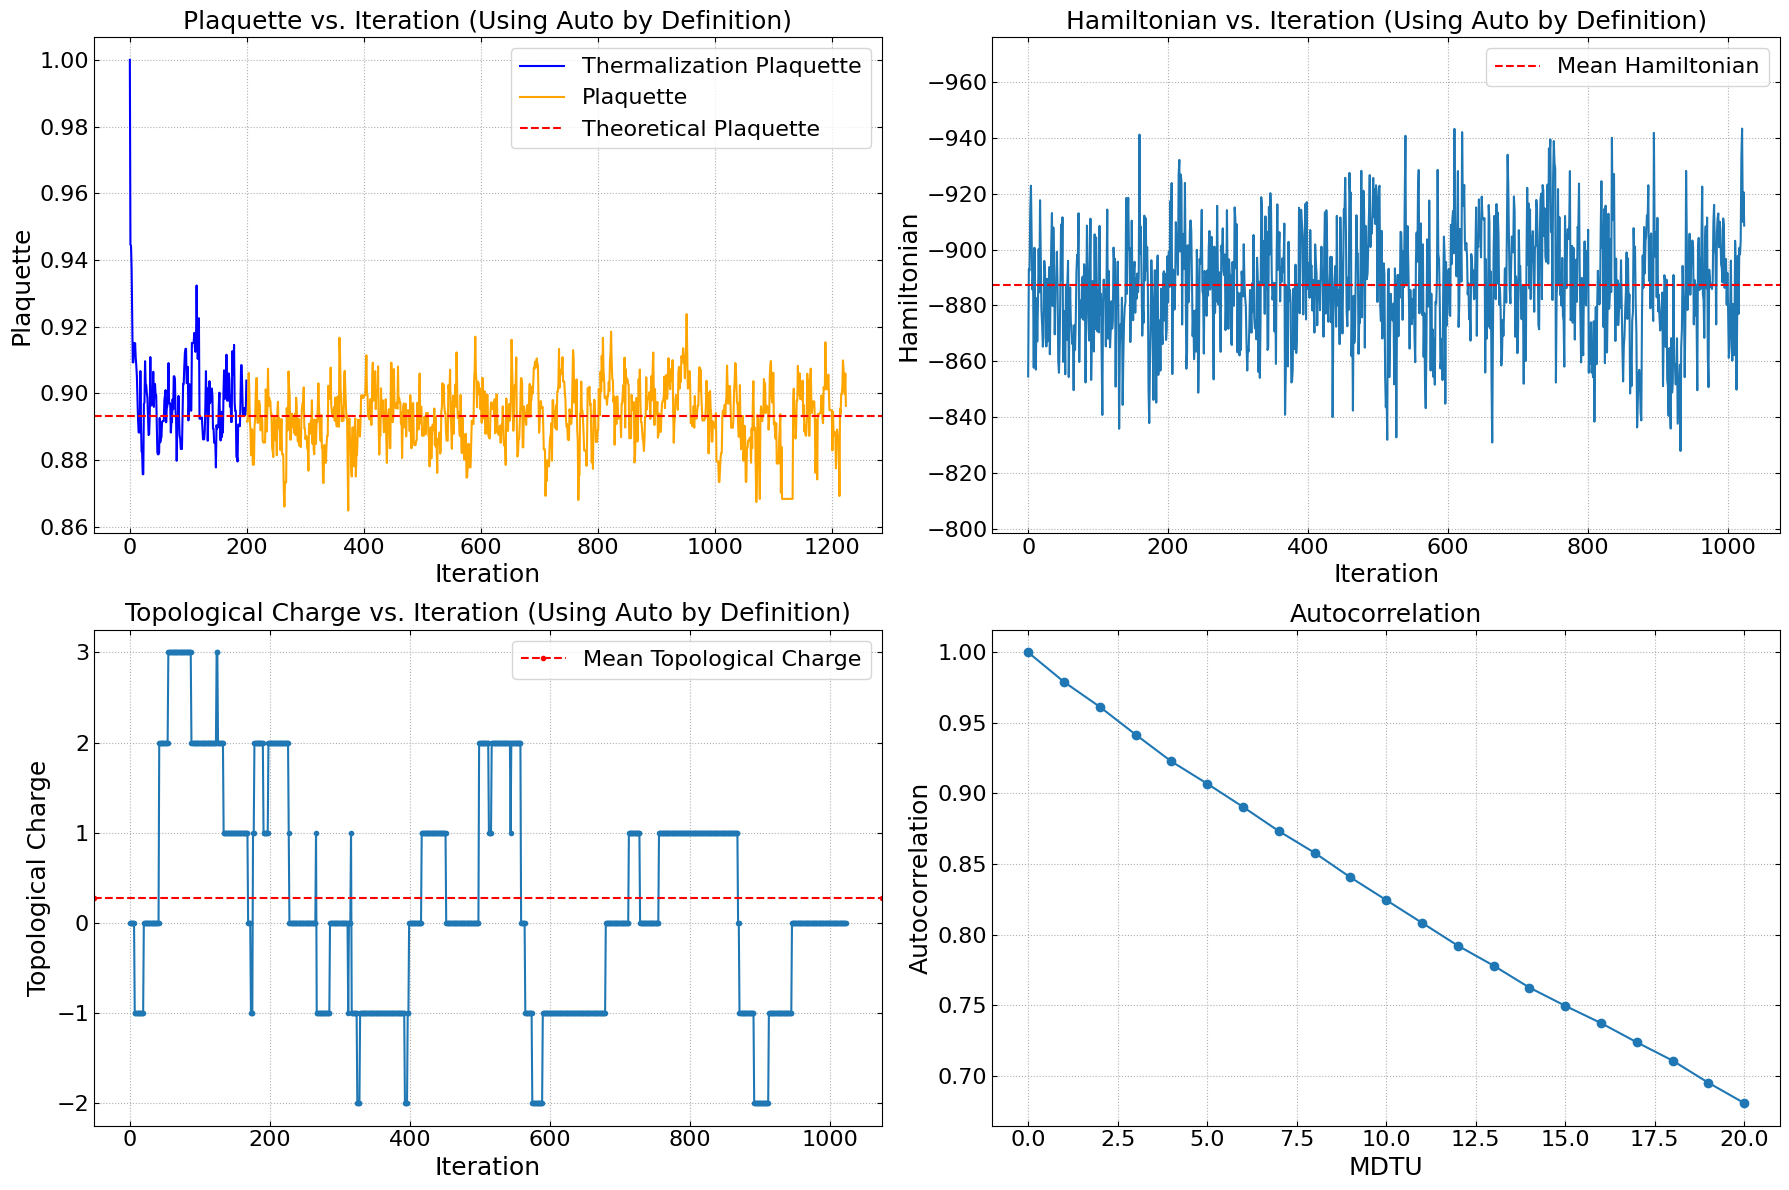

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8931418304564431
>>> Std of mean plaq:  0.00029181347176852575
Thermalization acceptance rate: 0.7850
Acceptance rate: 0.7871


In [4]:
def manual_transformation(U, epsilon=0.01):
    # noise = epsilon * (torch.randn_like(U) + 0.5)
    return U + torch.pi

# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=manual_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")

# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network:  48%|████▊     | 95/200 [00:07<00:05, 17.96it/s]

Epoch 00085: reducing learning rate of group 0 to 5.0000e-04.


Training Neural Network:  57%|█████▊    | 115/200 [00:09<00:04, 18.03it/s]

Epoch 00114: reducing learning rate of group 0 to 2.5000e-04.


Training Neural Network:  68%|██████▊   | 135/200 [00:11<00:03, 17.97it/s]

Epoch 00135: reducing learning rate of group 0 to 1.2500e-04.


Training Neural Network:  77%|███████▋  | 154/200 [00:12<00:02, 17.54it/s]

Epoch 00144: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00157: reducing learning rate of group 0 to 3.1250e-05.


Training Neural Network:  88%|████████▊ | 175/200 [00:14<00:01, 18.11it/s]

Epoch 00163: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00169: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00175: reducing learning rate of group 0 to 3.9063e-06.


Training Neural Network:  94%|█████████▍| 188/200 [00:15<00:00, 13.51it/s]

Epoch 00181: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00190: reducing learning rate of group 0 to 9.7656e-07.


Training Neural Network: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 00196: reducing learning rate of group 0 to 4.8828e-07.


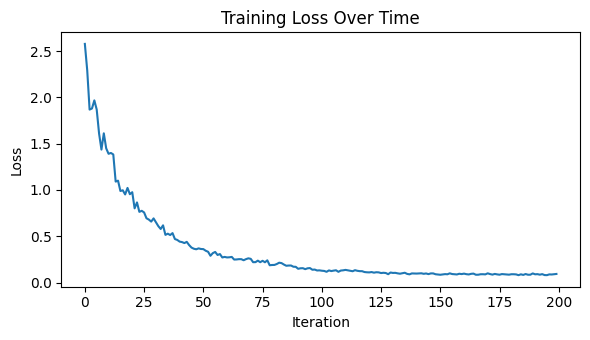

Running HMC: 100%|██████████| 1024/1024 [21:24<00:00,  1.25s/it] 


>>> Simulation completed


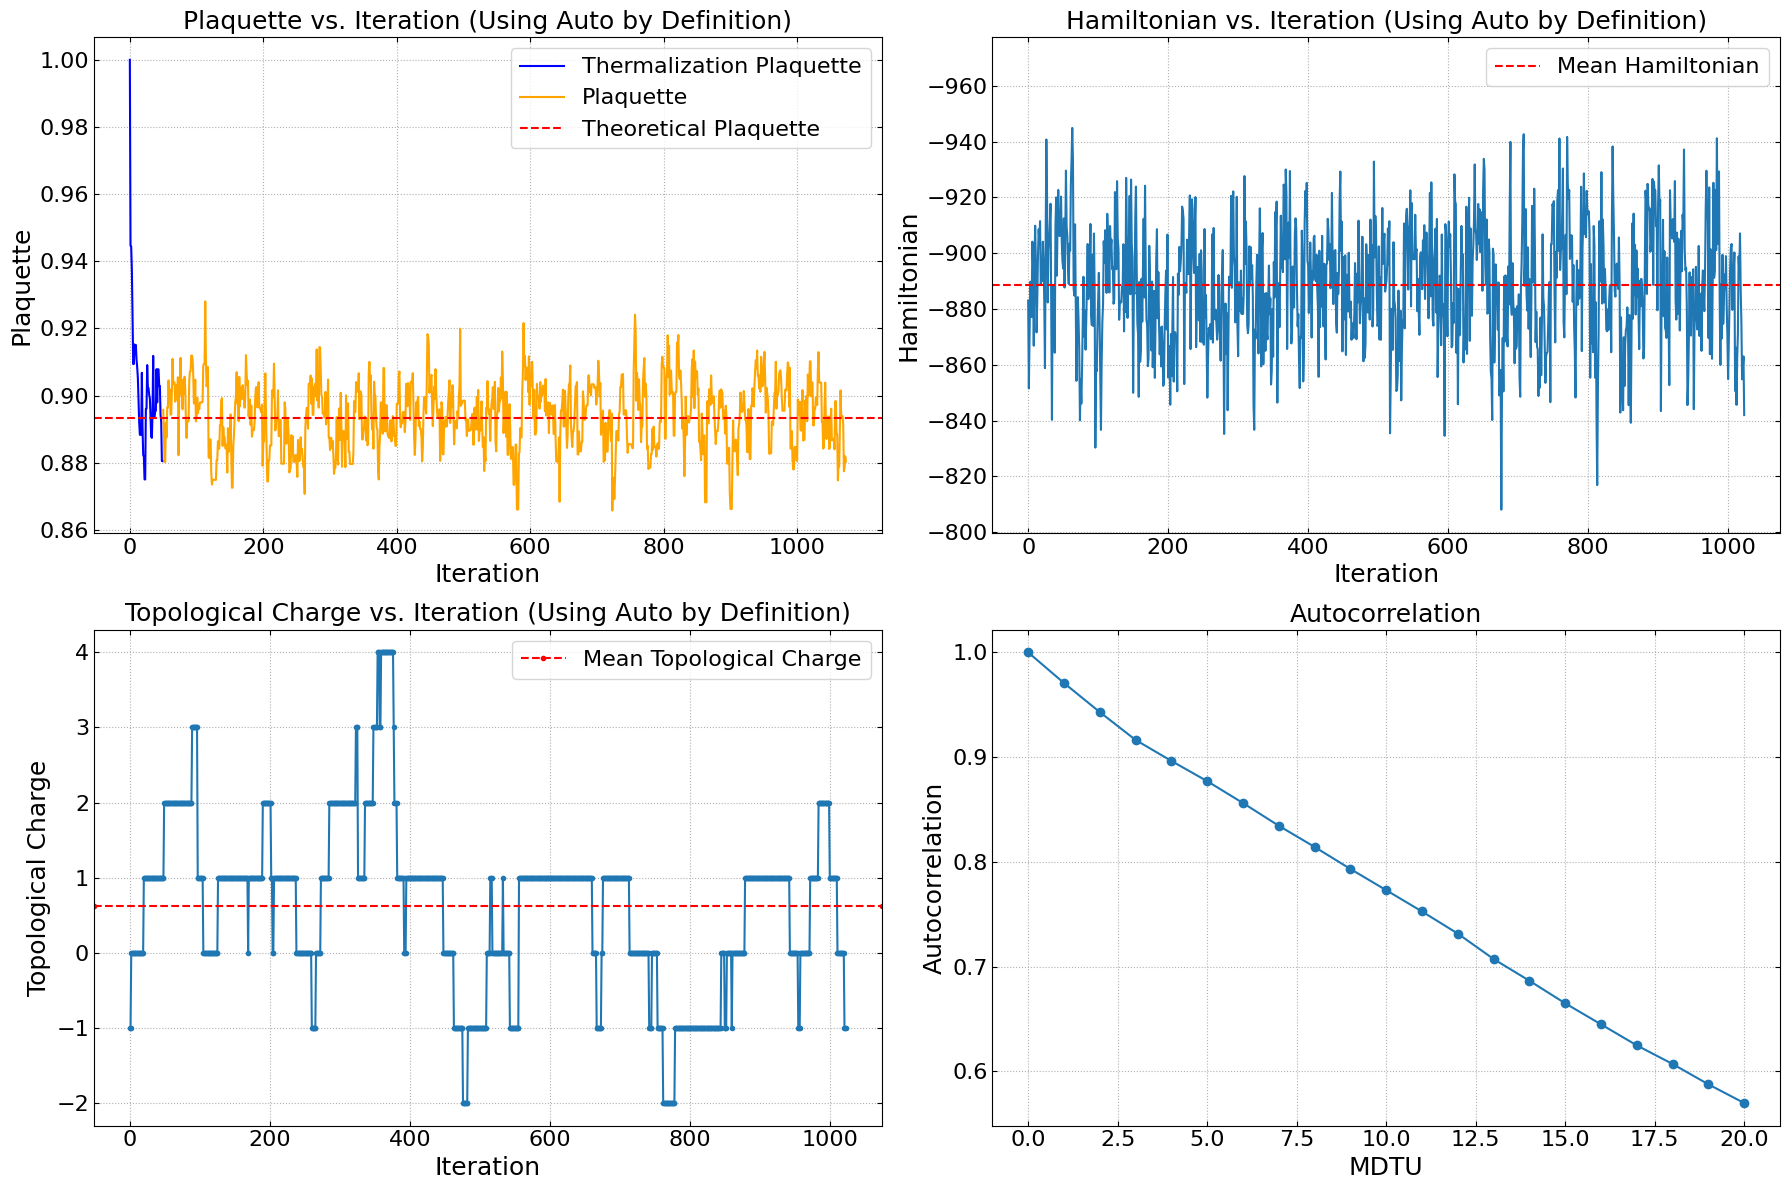

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8939739873749204
>>> Std of mean plaq:  0.00030407806281186053
Thermalization acceptance rate: 0.8200
Acceptance rate: 0.7930


In [5]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, epsilon=0.1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_epochs=200)

# Initialize HMC
n_thermalization_steps = 50
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)